<a href="https://colab.research.google.com/github/JINU6497/JINUrepo/blob/master/Design_ResNet_by_using_CIFAR_10_%2B_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''1. Module Import'''
import numpy as np  # 선형대수 관련 모듈
import matplotlib.pyplot as plt  # 결과 산출물을 시각화하는 모듈
 
import torch
import torch.nn as nn  # 인공 신경망 모델 설계에 필요한 함수들 모아 놓은 모듈 
import torch.nn.functional as F # torch.nn 중에서도 자주 쓰이는 functional 함수들을 따로 F로 지정 
from torchvision import transforms, datasets  # Computer vision 분야에서 자주 이용되는 torchvision 내의 함수 임포트

In [2]:
'''2. 딥러닝 모델 설계에 활용하는 장비 확인'''
if torch.cuda.is_available():
  DEVICE=torch.device('cuda')
else:
  DEVICE=torch.device('cpu')
 
print("Using pytorch version:",torch.__version__,'Device:',DEVICE)

Using pytorch version: 1.9.0+cu102 Device: cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
'''3. Data Augmentation 적용한 CIFAR-10 데이터 다운로드(Train과 Test set 분리)'''
train_dataset=datasets.CIFAR10(root="../data/Fashion,MNIST",train=True,download=True,
                               transform=transforms.Compose([transforms.RandomHorizontalFlip(),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize((0.5,0.5,0.5),
                                                             (0.5,0.5,0.5))]))
test_dataset=datasets.CIFAR10(root="../data/Fashion,MNIST",train=False,
                               transform=transforms.Compose([transforms.RandomHorizontalFlip(),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize((0.5,0.5,0.5),
                                                             (0.5,0.5,0.5))]))
 
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)


Extracting ../data/Fashion,MNIST/cifar-10-python.tar.gz to ../data/Fashion,MNIST


transforms.Compose()는 불러오는 이미지 데이터 전처리 및 Augmentation을 다양하게 적용할 때 이용하는 method. 즉, Compose의 괄호 안에 있는 처리 과정을 거친 데이터를 불러오는 것을 의미.
RandomHorizontalFlip은 50%확률로 좌우 반전하는 것을 의미
Normalize는 ToTensor()로 전환된 이미지에 대해 또 다른 정규화를 진행하는 것을 의미. 정규화를 진행할 때 평균과 표준편차가 필요한데, RGB순으로 평균을 0.5씩 적용하고, 다음 괄호에서는 표준편차를 0.5씩 적용하는 것

In [5]:
'''4. 데이터 확인'''
for (X_train, Y_train) in train_loader:
  print('X_train:',X_train.size(),'type:',X_train.type())
  print('Y_train:',Y_train.size(),'type:',Y_train.type())
  break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

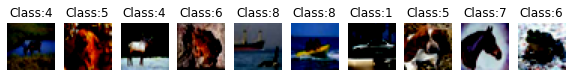

In [6]:
pltsize=1
plt.figure(figsize=(10*pltsize,pltsize))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i],(1,2,0)))
  plt.title('Class:'+str(Y_train[i].item()))

In [48]:
'''5. Convolutional Neural Network(CNN) 모델 설계하기'''

class BasicBlock(nn.Module):
  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1=nn.Conv2d(in_planes,planes,kernel_size=3,stride=stride,padding=1,bias=False)
    self.bn1=nn.BatchNorm2d(planes)
    self.conv2=nn.Conv2d(planes,planes,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn2=nn.BatchNorm2d(planes)

    self.shortcut=nn.Sequential()
    if stride!=1 or in_planes!=planes:
      self.shortcut=nn.Sequential(
          nn.Conv2d(in_planes,planes,kernel_size=1,stride=stride,bias=False),
          nn.BatchNorm2d(planes))
      
  def forward(self,x):
    out=F.relu(self.bn1(self.conv1(x)))
    out=self.bn2(self.conv2(out))
    out+=self.shortcut(x)
    out=F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, num_classes=10):
    super(ResNet,self).__init__()
    self.in_planes=16

    self.conv1=nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn1=nn.BatchNorm2d(16)
    self.layer1=self._make_layer(16,2,stride=1)
    self.layer2=self._make_layer(32,2,stride=2)
    self.layer3=self._make_layer(64,2,stride=2)
    self.linear=nn.Linear(64,num_classes)

  def _make_layer(self, planes, num_blocks,stride):
    strides=[stride]+[1]*(num_blocks-1)
    layers=[]
    for stride in strides:
      layers.append(BasicBlock(self.in_planes,planes,stride))
      self.in_planes=planes
    return nn.Sequential(*layers)

  def forward(self,x):
    out=F.relu(self.bn1(self.conv1(x)))
    out=self.layer1(out)
    out=self.layer2(out)
    out=self.layer3(out)
    out=F.avg_pool2d(out,8)
    out=out.view(out.size(0),-1)
    out=self.linear(out)
    return out

self.conv1=nn.conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1): 

in_channel: 이미지에 직접 Convolution 연산을 진행하는 Filter의 크기는 상관 없지만, 채널 수를 이미지의 채널 수와 동일하게 맞춰야 한다. 동일한 위치에 있으며 앞뒤로 존재하는 RGB 픽셀에 대해 동시에 Convolution을 진행해야 하기 때문. 따라서 이미지의 채널 수와 동일하게 채널 수를 3으로 설정.

out_channel은 8이므로 해당 Convolution 연산 결과는 Depth가 8인 Feature map이 생성 될 것.

kernel_size는 filter의 크기를 설정해주는 부분.

log_softmax()를 이용하여 0부터 9까지 총 10가지 경우의 수 중 하나로 분류하는 일을 확률 값 계산.일반적인 softmax가 아닌 log_softmax()를 이용하는 이유는 MLP모델이 Back propagation을 진행할 때 loss 값에 대한 gradient값을 좀 더 원활하게 계산할 수 있기 때문에. log 함수 그래프의 기울기가 부드럽게 변화하는 것을 생각해보면 직관적으로 이해할 수 있다.





In [49]:
'''6. Optimizer, Objective Fundtion 설정'''
 
model=ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()
 
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [50]:
'''7. CNN모델 학습 진행하면서 Train데이터에 대한 모델의 성능 확인하는 함수 정의'''
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx,(image,label) in enumerate(train_loader):
    image=image.to(DEVICE)
    label=label.to(DEVICE)
    optimizer.zero_grad()
    output= model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
 
    if batch_idx %log_interval ==0:
      print("Train Epoch:{}[{}/{}({:.0f}%)]\tTrain Loss:{:.6f}".format(Epoch, batch_idx*len(image),
                                                                       len(train_loader.dataset),100.*batch_idx/len(train_loader),loss.item()))

In [51]:
'''8. 학습 과정 속에서 Test 데이터에 대한 모델 성능 확인하는 함수 정의'''
 
def evaluate(model, test_loader):
  model.eval()
  test_loss=0
  correct=0
  with torch.no_grad():
    for image, label in test_loader:
      image=image.to(DEVICE)
      label=label.to(DEVICE)
      output = model(image)
 
      test_loss += criterion(output, label).item()
      prediction=output.max(1,keepdim=True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss/=len(test_loader.dataset)
  test_accuracy=100.*correct/len(test_loader.dataset)

  return test_loss, test_accuracy

In [52]:
'''9. CNN학습을 실행하면서 Test set의 Reconstruction Error 확인'''
for Epoch in range(1,EPOCHS+1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH:{}], \tTest Loss: {:.4f}, \tTest Accuracy:{:.2f}% \n".format(Epoch,test_loss, test_accuracy))

Train Epoch:1[0/50000(0%)]	Train Loss:2.506530
Train Epoch:1[6400/50000(13%)]	Train Loss:1.331616
Train Epoch:1[12800/50000(26%)]	Train Loss:1.177642
Train Epoch:1[19200/50000(38%)]	Train Loss:1.179705
Train Epoch:1[25600/50000(51%)]	Train Loss:1.026020
Train Epoch:1[32000/50000(64%)]	Train Loss:1.121610
Train Epoch:1[38400/50000(77%)]	Train Loss:0.909776
Train Epoch:1[44800/50000(90%)]	Train Loss:1.524731

[EPOCH:1], 	Test Loss: 0.0323, 	Test Accuracy:62.46% 

Train Epoch:2[0/50000(0%)]	Train Loss:0.837573
Train Epoch:2[6400/50000(13%)]	Train Loss:0.811295
Train Epoch:2[12800/50000(26%)]	Train Loss:0.960691
Train Epoch:2[19200/50000(38%)]	Train Loss:0.869237
Train Epoch:2[25600/50000(51%)]	Train Loss:1.061998
Train Epoch:2[32000/50000(64%)]	Train Loss:0.856571
Train Epoch:2[38400/50000(77%)]	Train Loss:0.652171
Train Epoch:2[44800/50000(90%)]	Train Loss:0.753674

[EPOCH:2], 	Test Loss: 0.0272, 	Test Accuracy:69.38% 

Train Epoch:3[0/50000(0%)]	Train Loss:1.003039
Train Epoch:3[6400/50

ResNet의 특징은 Shortcut을 정의하는 부분이 있음. Shortcut은 기존의 값과 Convolution 및 Batch Normalization한 결과를 더하는 과정을 의미. 이때 Stride값이 1이 아니거나 in_planes가 planes와 같지 않다면, 즉 두 번째 블록부터 적용되는 Shortcut을 정의. 

_make_layer 부분에서는 인자 값으로 주어지는 stride를 이용해 stride 범위를 BasicBlock 마다 설정할 수 있도록 정의. 이후, strides의 범위인 stride값을 통해 생성한 BasicBlock의 결과값을 리스트에 추가. 이후, 반복문을 실행하면서 self.in_planes값을 매번 업데이트해 BasicBlock을 새로 생성하기 위해 self.in_planes를 planes 값으로 업데이트함. 이 과정은 Shortcut을 계산하기 위함.